## Calculate Cloud Fractions

In [1]:
import json
import glob
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd    
import xarray as xr

In [2]:
#data_dir = '/home/hanna/MS-suppl/files/'
data_dir = '/uio/hume/student-u89/hannasv/MS-suppl/'
sat_dir = '/uio/lagringshotell/geofag/projects/miphclac/hannasv/'
save_dir = '/uio/lagringshotell/geofag/students/metos/hannasv/satelite_data/'

In [3]:
def read_dlon_dlat(data_dir):
    
    nc_files = glob.glob(data_dir+'*small*.json')    
    #print(nc_files[-1])
    with open(nc_files[-1]) as f:
        d =  json.load(f)
    
    d_phi      = d['dphi'] 
    d_theta    = d['dtheta'] 
    cell_areas = d['cell_area']
    lat_array  = d['lat'] 
    lon_array  = d['lon']
    return d_phi, d_theta, cell_areas, lat_array, lon_array

In [4]:
d_phi, d_theta, cell_areas, lat_array, lon_array = read_dlon_dlat(data_dir)

In [5]:
def clean_file(satfil):
    if satfil.split('.')[-1] == 'grb':
        cloudMask = xr.open_dataset(satfil, engine = 'cfgrib')
        o = cloudMask['p260537'].values.reshape( (3712, 3712) )
        
        o[o>=3.0]=np.nan
        o[o==1.0]=0
        o[o==2.0]=1.0
    else:
        cloudMask = xr.open_dataset(satfil)
        o = cloudMask['cloudMask'].values.reshape( (3712, 3712) )
    return o

In [6]:
def area_grid_cell(c_lat, d_lat, d_lon):
        R = 6371000  # in M
        # area er egentlig R**2
        area = R*(np.sin((c_lat + d_lat)*np.pi/180) - np.sin((c_lat - d_lat)*np.pi/180) )*(2*d_lon*np.pi/180) # R**2
        return np.abs(area)

In [7]:
def get_dict_with_all_keys():
    ex_fil = glob.glob(data_dir + '*ERA5*.json')
    #print(ex_fil)
    merged_dict = {}
    
    for fil in ex_fil:
        with open(fil, 'r') as f:
            data_grid = json.load(f)
        merged_dict.update(data_grid)   
    
    return merged_dict

In [8]:
data_dict = get_dict_with_all_keys()

In [29]:
def calc_fraction_one_cell(lat = '30.25', lon = '19.25', cmk = None, data = None):

    if data:
        ## Improvements : This should read the files. 
        ex = data[lat][lon]
        fraction = 0.0

        ERA_area = area_grid_cell(float(lat), 0.25/2, 0.25/2)
        SAT_area = 0.0

        index = ex['centre']['index']
        area  = ex['centre']['area']
        
        SAT_area = np.nansum(area)
        fraction = np.nansum(np.array(area)*np.array(cmk[index]) )
        
        for key, item in ex.items():
            if len(index) == len(area):
                index = ex[key]['index']
                area  = ex[key]['area']

                SAT_area = np.nansum(area)
                fraction = np.nansum(np.array(area)*np.array(cmk[index]) )
            else:
                return np.nan, (lat, lon)
        
        return fraction/SAT_area, np.isnan(np.array(cmk[index])).sum()
    else:
        print('Please send data as a attribute.')
        return

In [30]:
def compute(satfil, 
            lats = np.arange(30.0, 50.25, 0.25), 
            lons = np.arange(-15.0, 25.25, 0.25)):
    
    o = clean_file(satfil)
    d_phi, d_theta, cell_areas, lat_array, lon_array = read_dlon_dlat(data_dir)
    clouds = o.reshape(-1)

    data_dict = get_dict_with_all_keys()

    GRID = np.zeros((len(lats), len(lons)) )
    GRID_NAN = np.zeros((len(lats), len(lons)) )
    
    for i,lat in enumerate(lats):
        for j, lon in enumerate(lons):
            fraction, nbr_nan = calc_fraction_one_cell(lat = str(lat), 
                                                       lon = str(lon), 
                                                       cmk = clouds, 
                                                       data = data_dict)

            GRID[i][j] = fraction
            GRID_NAN[i][j] = nbr_nan

    return GRID, GRID_NAN

In [31]:
#data_grid = get_dict_with_all_keys()
#lats = np.arange(-15.0, 25.0, 0.25)
#lons = np.arange(30.0, 50.0, 0.25)

#sat_dir = '/home/hanna/lagrings/sat_images_2004_2011/'
sat_files = glob.glob(sat_dir + "*2004*13*.grb")

# Testing pynio engine opens same as cfgrib

In [32]:
import seaborn as sns

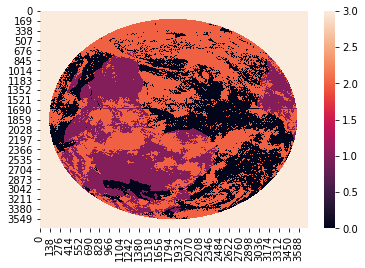

In [33]:
cloudMask = xr.open_dataset(sat_files[0], engine = 'pynio') # engine cfgrib lapt
#rint(cloudMask)
# = cloudMask['p260537'].values.reshape( (3712, 3712) )
o = cloudMask['CLOUDM_P30_GSV0_I207'].values.reshape( (3712, 3712) )
sns.heatmap(o)
plt.show()

In [34]:
import glob
import xarray as xr
import numpy as np

def timestamp(filename):
    """
    Returns the numpy datetime 64 [ns] for the current date.
    This is a bit hardcoded at the moment ....
    """
    splits = filename.split('-')
    ts = splits[5]
    year = ts[:4]
    month = ts[4:6]
    day = ts[6:8]
    hr = ts[8:10]
    minuts = ts[10:12]
    sek = ts[12:14]
    # TODO make sure all filenames have seconds
    return np.datetime64( year+"-"+month+"-"+day+"T"+hr+":"+minuts+":"+sek )

def merge_ts_to_one_dataset(grb_files, 
                            lat = np.arange(30.0, 50.25, 0.25), 
                            lon = np.arange(-15.0, 25.25, 0.25)):
    """
    grib_files : list of files
        typically one year?
    """
    data_grid = get_dict_with_all_keys()
    
    counter = 0
    for filename in grb_files:
        if counter == 0:
            #print("enters 0")
            #clou = calc_all(filename, nc_file = nc_files[0])
            cloud_fraction, nans = compute(filename, lat, lon)
            ds = xr.Dataset({'tcc': (['latitude', 'longitude'],   cloud_fraction),
                             'nr_nans':(['latitude', 'longitude'], nans),
                             #'nr_cells':(['latitude', 'longitude'], cnt_cells)
                                 },
                             coords={'longitude': (['longitude'], lon),
                                     'latitude': (['latitude'], lat),
                                    })

            ts = timestamp(filename)
            ds['time'] = ts

            # Add time as a coordinate and dimension.
            ds = ds.assign_coords(time = ds.time)
            ds = ds.expand_dims(dim = 'time')
            counter += 1

        else:
            #clm, cnt_cells, cnt_nans = calc_all(filename, nc_file = nc_files[0])
            cloud_fraction, nans = compute(filename, lat, lon)
            new_ds = xr.Dataset({'tcc': (['latitude', 'longitude'],  cloud_fraction),
                                 'nr_nans':(['latitude', 'longitude'], nans),
                                 #'nr_cells':(['latitude', 'longitude'], cnt_cells)
                                },
                                  coords={'longitude': (['longitude'], lon),
                                          'latitude': (['latitude'], lat),
                                           })

            ts = timestamp(filename)
            new_ds['time'] = ts

            # Add time as a coordinate and dimension.
            new_ds = new_ds.assign_coords(time = new_ds.time)
            new_ds = new_ds.expand_dims(dim = 'time')
            
            try:          
                ds = ds.merge(new_ds)
            except xr.MergeError:
                # Happens if MS1 and MS2 have taken a image at the same time
                print("Filename not included {}".format(filename))
                
            counter += 1
        #print("completed {}/{} files".format(counter, len(grb_files)))
    return ds


In [35]:
#df1, df2, grid = compute(sat_files[0])

In [36]:
#sns.heatmap(grid)

In [37]:
#ds  = merge_ts_to_one_dataset(sat_files[:2])

In [38]:
#ds

In [39]:
#import seaborn as sns

In [40]:
#sns.heatmap(ds['tcc'].values[0, :, :])

In [41]:
import multiprocessing as mp

In [42]:
from multiprocessing import Process

def f(subset, i):
    
    ds = merge_ts_to_one_dataset(subset, 
                                 lat =  np.arange(30.0, 50.25, 0.25) , 
                                 lon = np.arange(-15.0, 25.25, 0.25) )

    ds.to_netcdf(path = save_dir+'cloud_fractions_heilt_nytt_{}.nc'.format(i), 
                 engine='netcdf4',  
                 encoding ={'tcc': {'zlib': True, 'complevel': 9},
                           'nr_nans': {'zlib': True, 'complevel': 9} })
    return 

In [43]:
def get_list_remainig_files():
    search_str_finished = '*heilt*.nc'
    sat_dir = '/uio/lagringshotell/geofag/projects/miphclac/hannasv/'
    save_dir = '/uio/lagringshotell/geofag/students/metos/hannasv/satelite_data/'
    
    files = glob.glob(save_dir + search_str_finished)

    failed = []
    for i, fil in enumerate(files):
        if i == 0:
            ds = xr.open_dataset(fil)
        else:
            try:
                ds = ds.merge(xr.open_dataset(fil))
            except xr.MergeError:
                failed.append(fil)
            #print(i)
    sat_files = glob.glob(sat_dir + "*.grb")
    
    remaining_files = []
    for fil in sat_files:
        if not timestamp(fil) in ds.time.values:
            remaining_files.append(fil)
            
    return remaining_files

In [45]:
sat_files = get_list_remainig_files()

In [46]:
len(sat_files)

86590

In [47]:
size = len(sat_files)

In [48]:
size/(200)

432

In [49]:
m = 5000
for j, sub in enumerate(np.array_split(sat_files, 2000)):
    f(sub, m)
    m+=1
    #print('Finished {}/{}'.format(i+j*i+1, len(alls)))

Filename not included /uio/lagringshotell/geofag/projects/miphclac/hannasv/MSG2-SEVI-MSGCLMK-0100-0100-20070320200000.000000000Z-20070320201252-1359310.grb
Filename not included /uio/lagringshotell/geofag/projects/miphclac/hannasv/MSG2-SEVI-MSGCLMK-0100-0100-20070320210000.000000000Z-20070320211251-1359310.grb
Filename not included /uio/lagringshotell/geofag/projects/miphclac/hannasv/MSG2-SEVI-MSGCLMK-0100-0100-20070320220000.000000000Z-20070320221252-1359310.grb
Filename not included /uio/lagringshotell/geofag/projects/miphclac/hannasv/MSG2-SEVI-MSGCLMK-0100-0100-20070320230000.000000000Z-20070320231251-1359310.grb
Filename not included /uio/lagringshotell/geofag/projects/miphclac/hannasv/MSG2-SEVI-MSGCLMK-0100-0100-20070321000000.000000000Z-20070321001309-1359310.grb
Filename not included /uio/lagringshotell/geofag/projects/miphclac/hannasv/MSG2-SEVI-MSGCLMK-0100-0100-20070321010000.000000000Z-20070321011251-1359310.grb
Filename not included /uio/lagringshotell/geofag/projects/miphcl

In [ ]:
new_ds

In [ ]:
len(alls)

In [ ]:
for t in ds.time.values:
    ax = sns.heatmap(ds.sel(time = t)['tcc'].values)
    ax.set_title(t)
    plt.savefig('/home/hanna/{}.png'.format(t))
    plt.show()

In [ ]:
ds.sel(time = '2004-07-23T19:00:00')['tcc'].values

In [ ]:
sns.heatmap(ds.sel(time = '2004-07-23T19:00:00')['tcc'].values)

# Write file and generate filename.

In [ ]:
def output_filename(var, start, stop, add_text_begin = ""):
    """
    Add test train or valid in front when this is appropriate.

    OBS: Var should be in terms of variables in the era-interim datasets.
    """
    return (save_dir + add_text_begin + var + "_" + start + "_" +
                stop + "_" + season_str + ".nc")
